In [2]:
using GraphPPL
using Rocket
using ReactiveMP
using Distributions
using Plots
using LinearAlgebra
using Random
using JLD
using Parameters
import ProgressMeter

┌ Info: Precompiling ReactiveMP [a194aa59-28ba-4574-a09c-4a745416d6e3]
└ @ Base loading.jl:1317
┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1317


In [3]:
import ReactiveMP.messageout

In [4]:
data_seed, params_seed = 42, 420

(42, 420)

In [5]:
include("../helpers/data.jl")

generate_data

In [6]:
struct DummyDistribution
end

Distributions.entropy(dist::DummyDistribution) = ReactiveMP.InfCountingReal(0.0, -1)

@marginalrule typeof(+)(:in1_in2) (m_out::PointMass, m_in1::NormalDistributionsFamily, m_in2::NormalDistributionsFamily, ) = begin 
    return DummyDistribution()
end


In [7]:
function ssm(series, order)
    inputs = [reverse!(series[1:order])]
    outputs = [series[order + 1]]
    for x in series[order+2:end]
        push!(inputs, vcat(outputs[end], inputs[end])[1:end-1])
        push!(outputs, x)
    end
    return inputs, outputs
end

ssm (generic function with 1 method)

In [23]:
order_y, order_u, order_h = 2, 2, 2
full_order = order_h + order_y + order_u
Y = zeros(full_order, order_y); Y[1:order_y, 1:order_y] = diageye(order_y);
U = zeros(full_order, order_u); U[order_y+1:order_y+order_u, 1:order_u] = diageye(order_u);
H = zeros(full_order, order_h); H[full_order-order_h+1:full_order, 1:order_h] = diageye(order_h);

In [24]:
function shift(dim)
    S = Matrix{Float64}(I, dim, dim)
    for i in dim:-1:2
           S[i,:] = S[i-1, :]
    end
    S[1, :] = zeros(dim)
    return S
end

shift (generic function with 1 method)

In [326]:
# Nonlinear MAX model definition
@model [default_factorisation=MeanField()] function linear_max_mv(n, h_prior, w_prior, η_prior, τ_prior, y_prev, u, y_order, u_order, h_order)
    
    order = h_order + y_order + u_order
    
    obs_prec = 1e12;
    
    # initialize variables
    θ       = randomvar() where {form_constraint = FixedMarginalConstraint(MvNormalMeanPrecision(zeros(h_order), 1e12*diageye(h_order)))}
    w       = randomvar()
    h       = randomvar(n)
    uh      = randomvar(n)
    yuh     = randomvar(n)
    yuh_     = randomvar(n)
    y       = datavar(Float64, n)

    y_nodes = Vector{FactorNode}(undef, n)

    
    Ys = [Y*y_prev[t] for t in 1:n]
    Us = [U*u[t] for t in 1:n]
    
    AR_meta_1 = ARMeta(Multivariate, h_order, ARsafe())
    AR_meta_2 = ARMeta(Multivariate, order, ARsafe())
    
    h_0 ~ MvNormalMeanPrecision(h_prior[1], h_prior[2])
    w   ~ GammaShapeRate(w_prior[1], w_prior[2])
    θ   ~ MvNormalMeanPrecision(zeros(h_order), diageye(h_order))
    
    η   ~ MvNormalMeanPrecision(η_prior[1], η_prior[2])
    τ   ~ GammaShapeRate(1.0, 1.0)
    
    b = zeros(order); b[1] = 1.0;
    c = zeros(h_order); c[1] = 1.0;
    
    h_prev = h_0
    for t in 1:n
        
        h[t] ~ AR(h_prev, θ, w) where {q = q(y, x)q(γ)q(θ), meta = AR_meta_1}
        uh[t] ~ H*h[t] + Us[t]
        yuh[t] ~ uh[t] + Ys[t]
        yuh_[t] ~ AR(yuh[t], η, τ) where {q = q(y, x)q(γ)q(θ), meta = AR_meta_2}
        
        y_nodes[t], y[t] ~ NormalMeanPrecision(dot(yuh_[t], b) + dot(h[t], c), obs_prec)
        
        h_prev = h[t]
    end

    return θ, w, h, η, τ, y_nodes, y
end

linear_max_mv (generic function with 2 methods)

In [329]:
function linear_max_inference_mv(observations, observations_prev, controls;
                                 y_order, u_order, h_order,
                                 h_prior=(randn(h_order), diageye(h_order)),
                                 w_prior=(1.0, 1.0), η_prior=(zeros(y_order+u_order+h_order), diageye(y_order+u_order+h_order)),
                                 τ_prior=(1.0, 1.0), vmp_its=10)
    
    order = h_order + y_order + u_order
    
    n = length(observations)

    # define model
    model, (θ, w, h, η, τ, y_nodes, y) = linear_max_mv(n, h_prior, w_prior, η_prior, τ_prior, observations_prev, controls, y_order, u_order, h_order,
                                                      options = (limit_stack_depth = 500, ))
    
    h_buffer = Vector{Marginal}(undef, n)
    y_out_buffer = Vector{AbstractMessage}(undef, n)
    
    θ_buffer = nothing
    w_buffer = nothing
    η_buffer = nothing
    τ_buffer = nothing
    
    subscribe!(getmarginals(h), (x) -> copyto!(h_buffer, x))
    
    subscribe!(getmarginal(θ), (x) -> θ_buffer = x)
    subscribe!(getmarginal(η), (x) -> η_buffer = x)
    subscribe!(getmarginal(w), (x) -> w_buffer = x)
    subscribe!(getmarginal(τ), (x) -> τ_buffer = x)

    subscribe!(collectLatest(messageout.(ReactiveMP.getinterface.(y_nodes, :out))), 
                                         (x) -> copyto!(y_out_buffer, ReactiveMP.as_message.(x)))
    
    # initialize free energy
    fe_buffer = Vector()
    
    # subscribe
    fe_sub = subscribe!(score(BetheFreeEnergy(), model), (f) -> push!(fe_buffer, f))
    
    setmarginals!(h, MvNormalMeanPrecision(zeros(h_order), diageye(h_order)))
    setmarginal!(w, GammaShapeRate(w_prior[1], w_prior[2]))
    setmarginal!(θ, MvNormalMeanPrecision(zeros(h_order), diageye(h_order)))
    setmarginal!(τ, GammaShapeRate(τ_prior[1], τ_prior[2]))
    setmarginal!(η, MvNormalMeanPrecision(η_prior[1], η_prior[2]))
    
    setmessages!(h, MvNormalMeanPrecision(zeros(h_order), diageye(h_order)))
    
    ProgressMeter.@showprogress for _ in 1:vmp_its
        ReactiveMP.update!(y, observations)
    end
    
    # return the marginal values
    return fe_buffer, h_buffer, θ_buffer, w_buffer, η_buffer, τ_buffer, y_out_buffer
    
end

linear_max_inference_mv (generic function with 6 methods)

In [330]:
Random.seed!(data_seed)

n_samples = 1000
u = 3 .* sin.(collect(1:n_samples+10))
y_lat, y_obs, h_gen = generate_data(n_samples, narx, Dict(:order_y=>order_y, :order_u=>order_u, :order_e=>order_h),
                                                     Dict(:er_var=>1e-2, :u=>u));

In [331]:
observations_prev, observations = ssm(y_obs, order_y)
controls = ssm(u, order_u)[1]

1008-element Vector{Vector{Float64}}:
 [2.727892280477045, 2.5244129544236893]
 [0.4233600241796016, 2.727892280477045]
 [-2.2704074859237844, 0.4233600241796016]
 [-2.8767728239894153, -2.2704074859237844]
 [-0.8382464945967776, -2.8767728239894153]
 [1.9709597961563672, -0.8382464945967776]
 [2.9680747398701453, 1.9709597961563672]
 [1.2363554557252698, 2.9680747398701453]
 [-1.6320633326681093, 1.2363554557252698]
 [-2.9999706196521103, -1.6320633326681093]
 [-1.609718754001305, -2.9999706196521103]
 [1.2605011104799226, -1.609718754001305]
 [2.971822067084611, 1.2605011104799226]
 ⋮
 [-2.5664194559090623, -2.6939024414938535]
 [-0.07938225821119238, -2.5664194559090623]
 [2.4806386215960075, -0.07938225821119238]
 [2.7599717927589653, 2.4806386215960075]
 [0.5017996259213775, 2.7599717927589653]
 [-2.2177248028207854, 0.5017996259213775]
 [-2.8982832754114494, -2.2177248028207854]
 [-0.9141734707069559, -2.8982832754114494]
 [1.9104232070385518, -0.9141734707069559]
 [2.97858559860

In [332]:
train_size = 800
X_train, Y_train, U_train = observations_prev[1:train_size], observations[1:train_size], controls[1:train_size]
X_test, Y_test, U_test = observations_prev[train_size+1:end], observations[train_size+1:end], controls[train_size+1:end];

In [334]:
full_order = order_y + order_u + order_h
fe_, h_, θ_, w_, η_, τ_, y_out_ = linear_max_inference_mv(Y_train, X_train, U_train, y_order=order_y, u_order=order_u, w_prior=(1e-4, 1.0), η_prior=(zeros(full_order), diageye(full_order)), τ_prior=(1e-4, 1e-4), h_order=order_h, vmp_its=100);



Progress: 100%|█████████████████████████████████████████| Time: 0:00:16


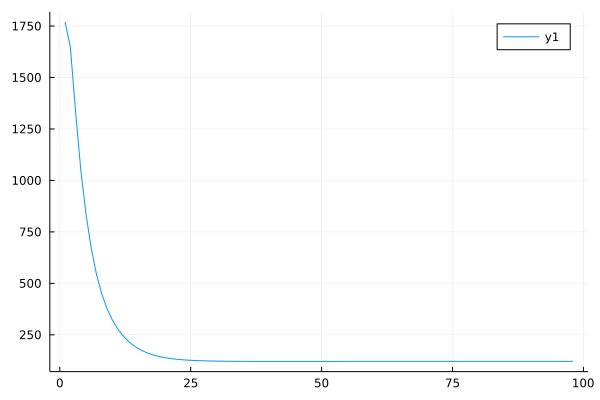

In [335]:
plot(fe_[3:end])

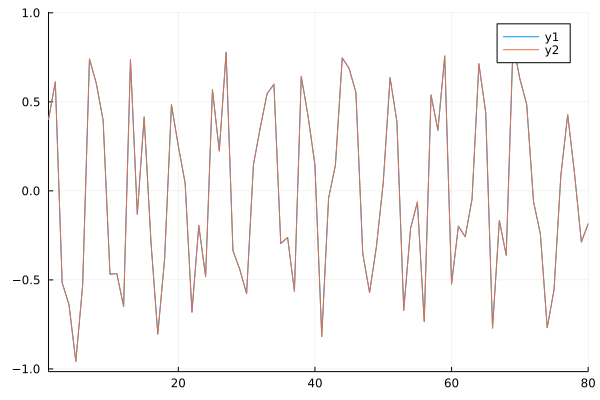

In [336]:
mfrom, mto = 1, 80
plot(mean.(y_out_), ribbon=sqrt.(cov.(y_out_)))
plot!(Y_train, xlims=(mfrom, mto))

In [337]:
mean(w_)

24.23933118753612

In [338]:
mean(τ_)

68.6264241444864

In [339]:
mean(η_)

6-element Vector{Float64}:
  0.006214712599337539
  0.001394682687183155
  0.07033448453628682
  0.0839883812047455
  0.8453598618293279
 -0.03127051179123959

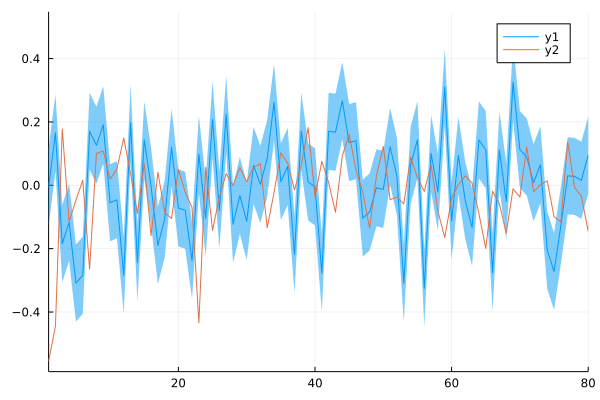

In [340]:
plot(first.(mean.(h_)), ribbon=sqrt.(first.(cov.(h_))))
plot!(h_gen, xlims=(mfrom, mto))

## KF-like prediction

In [341]:
function transition(γ, order)
    V = zeros(order, order)
#     V = diageye(order)
    V[1] = 1/γ
    return V
end

function shift(dim)
    S = Matrix{Float64}(I, dim, dim)
    for i in dim:-1:2
           S[i,:] = S[i-1, :]
    end
    S[1, :] = zeros(dim)
    return S
end

shift (generic function with 1 method)

In [342]:
# Nonlinear MAX model definition
@model [default_factorisation=MeanField()] function linear_max_prediction_mv_model(h_prior, η, w, τ, y_prev, u, full_order)
    
    h_order = length(h_prior[1])

    A = shift(h_order) # transition matrix
    V = transition(w, h_order)

    # initialize variables
    y_pred   = datavar(Float64)
    
    h_0 = randomvar() where {form_constraint = FixedMarginalConstraint(MvNormalMeanPrecision(h_prior[1], h_prior[2]))}

    # compile flow model
    h_0 ~ MvNormalMeanPrecision(h_prior[1], h_prior[2])
    
    Ah ~ A*h_0
    h ~ MvNormalMeanCovariance(Ah, V) where {q = q(Ah, h)q(V)}

    uh  ~ H*h + U*u
    yuh ~ uh + Y*y_prev
    
    c = zeros(h_order); c[1] = 1.0
    y_node, y ~ NormalMeanPrecision(dot(yuh, η) + dot(h, c), τ) where {q=FullFactorisation()}
    
    y_pred ~ NormalMeanPrecision(y, 1e-12)
    
    return h, h_0, y_node, y, y_pred
end

linear_max_prediction_mv_model (generic function with 1 method)

In [343]:
function linear_max_prediction_mv(observation_prev, control; full_order, h_prior, η, w, τ, vmp_its = 50)

    # define model
    model, (h, h_0, y_node, y, y_pred) = linear_max_prediction_mv_model(h_prior, η, w, τ, observation_prev, control, full_order,
                                                                        options = (limit_stack_depth = 500, ))
    
    h_order = length(h_prior[1])
    
    h_buffer = nothing
    h0_buffer = nothing
    y_out_buffer = nothing
    y_pred_buffer = nothing
    
    h_sub = subscribe!(getmarginal(h), (x) -> h_buffer = x)
    h0_sub = subscribe!(getmarginal(h_0), (x) -> h0_buffer = x)
    y_pred_sub = subscribe!(getmarginal(y), (x) -> y_pred_buffer = x)

    fe_buffer = Vector()
    
#     setmarginal!(y, NormalMeanPrecision(0.0, 1.0))
    setmessage!(h, MvNormalMeanPrecision(h_prior[1], h_prior[2]))
    
    # subscribe
    fe_sub = subscribe!(score(BetheFreeEnergy(), model), (f) -> push!(fe_buffer, f))
    
    for _ in 1:vmp_its
        ReactiveMP.update!(y_pred, 0.0)
    end
    
    # return the marginal values
    return fe_buffer, h_buffer, h0_buffer, y_pred_buffer
    
end

linear_max_prediction_mv (generic function with 2 methods)

In [344]:
h_prev = (mean(h_[end]), precision(h_[end]))
η = mean(η_)
w = mean(w_)
τ = mean(τ_)

fe_pred, h_pred, h0_pred, y_pred = linear_max_prediction_mv(X_test[1], U_test[1], full_order=full_order, h_prior=h_prev,η=η, w=w, τ=τ, vmp_its=1)

(Any[-Inf], Marginal(MvNormalWeightedMeanPrecision(
xi: [-6.483438818544318e-14, 12.5096106861045]
Λ: [24.239331187540834 -2.6434835527173886e-14; -2.6434835527173886e-14 67.38277807439691]
)
), Marginal(MvNormalMeanPrecision(
μ: [0.1856499693778323, 0.12346666472525879]
Λ: [67.39003884950593 -0.6999382334869784; -0.6999382334869784 67.47399873132862]
)
), Marginal(NormalWeightedMeanPrecision{Float64}(xi=-1.6252443411925885, w=11.720058366463274)))

In [407]:
predictions = []
h_prev = (mean(h_[end]), precision(h_[end]))
η = mean(η_)
w = mean(w_)
τ = mean(τ_)

batch = 1
for i in batch:length(X_test)
    fe_pred, h_pred, h0_pred, y_pred = linear_max_prediction_mv(X_test[i], U_test[i], full_order=full_order, h_prior=h_prev,η=η, w=w, τ=τ, vmp_its=1)
    push!(predictions, y_pred)
    
#     _, h_, θ_, w_, η_, τ_, y_out_ = linear_max_inference_mv([Y_test[i]], [X_test[i]], [U_test[i]], y_order=order_y, u_order=order_u, w_prior=(shape(w_), rate(w_)), 
#                                                             η_prior=(mean(η_), diageye(full_order)), τ_prior=(shape(τ_), rate(τ_)), h_order=order_h, vmp_its=100);
    
    _, h_, θ_, w_, η_, τ_, y_out_ = linear_max_inference_mv(Y_test[i-batch+1:i], X_test[i-batch+1:i], U_test[i-batch+1:i], y_order=order_y, u_order=order_u, w_prior=(shape(w_), rate(w_)), 
                                                            η_prior=(mean(η_), precision(η_)), τ_prior=(shape(τ_), rate(τ_)), h_order=order_h, vmp_its=10);
    
    h_prev = (mean(h_[end]), precision(h_[end]))
    η = mean(η_)
    w = mean(w_)
    τ = mean(τ_)
    
end

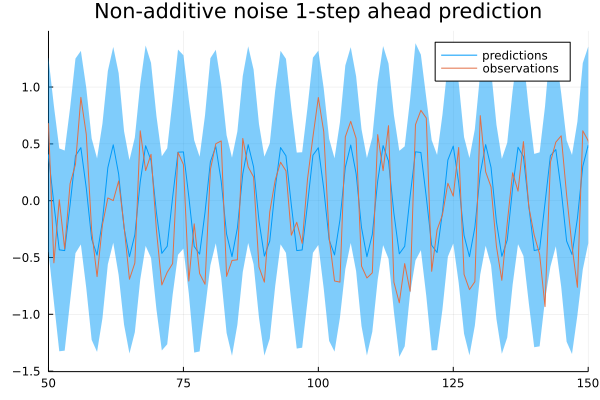

In [408]:
plot(mean.(predictions), ribbon=sqrt.(first.(cov.(predictions))), label="predictions")
plot!(Y_test, xlims=(50, 150), title="Non-additive noise 1-step ahead prediction", label="observations")